*Supporting textbook chapters for week 6: Chapters 8.1, 8.2, 8.5.1 to 8.5.3*

Lecture 6, topics:
* Euler method
* Runge-Kutta methods
* Leapfrog and Verlet Methods --- energy conservation

Consider ODE(s) with some initial condition(s):

* 1D: $\quad\displaystyle \frac{\text d x}{\text d t} = f(x, t)\quad \text{with}\quad x(t=0)=x_0.$
* $n$D: $\quad\displaystyle \frac{\text d x_i}{\text d t} = f_i(x_1,\dots{},x_n, t)\quad \text{with}\quad x_i(t=0)=x_{i0}.$
* higher order, e.g.: 
$$\frac{\text d^3 x}{\text d t^3} =f(x, t)\quad \Leftrightarrow \quad \frac{\text d x}{\text d t} = v,\ \frac{\text d v}{\text d t} = a,\ \frac{\text d a}{\text d t}=f.$$

These equations can be impossible to solve anaytically, but easy to solve on a computer.

## SciPy's canned routines

* Python has built-in ODE solvers called `odeint` (older) and `solve_ivp` (preferred) located in the `scipy.integrate` module.
    (*Aside: This module also contains a bunch of integration functions that can do Gaussian quadrature, Simpson's rule etc.*).  https://docs.scipy.org/doc/scipy/tutorial/integrate.html

* `odeint` uses the LSODA algorithm.
    Very powerful but lots of automatic knobs make it difficult to track what is actually going on (error estimate?).
    
* `solve_ivp` allows more user control.
    Still, useful to know how these methods work under the hood to really know how to use canned routines.

* If that doesn't matter to your specific application, then just use `odeint` or `solve_ivp`.
    However, if it does matter, then you can write your own ODE solver

# Euler method

Let's solve for 
$$ \frac{\text d x}{\text d t} = -x^3(t) + \sin(t) $$

In [2]:
# load euler-odeint.py  modified from Newman
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def f(x,t):
    return -x**3 + np.sin(t)

a = 0.0           # Start of the interval
b = 10.0          # End of the interval
N = 1000            # Number of steps
h = (b-a)/N       # Size of a single step
x = 0.0           # Initial condition

tpoints = np.arange(a,b,h)
xpoints = []
for t in tpoints:
    xpoints.append(x)
    x += h*f(x,t)

#also solve by odeint
x_new = odeint(func=f, y0=0, t=tpoints)

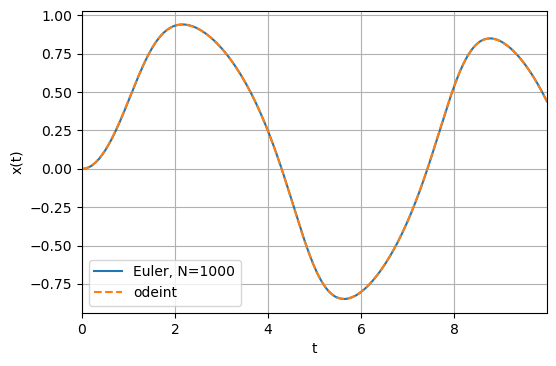

In [3]:
plt.figure(dpi=100)
plt.plot(tpoints, xpoints, label='Euler, N={:d}'.format(N))
plt.xlabel("t")
plt.ylabel("x(t)")
plt.plot(tpoints, x_new, '--', label='odeint')
plt.autoscale(enable=True, axis='x', tight=True) 
plt.grid() 
plt.legend()

* The Euler method has error $O(h^2)$ at each step
* integrating across the whole interval: global error is $O(h)$ (see eqn 8.8, p. 331):
    $$\text{Taylor expansion} \Rightarrow x(t+h) = x(t) + h\frac{dx}{dt} + \overbrace{ \frac{h^2}{2} \frac{d^2x}{dt^2} } ^{\epsilon} + O(h^3)$$
    $$\sum\epsilon = \sum_{k=0}^{N-1}\frac{h^2}{2}\left. \frac{d^2x}{dt^2} \right|_{x_k, t_k} = \frac{h}{2}\sum_{k=0}^{N-1}h\left.\frac{df}{dt}\right|_{x_k, t_k}\\
    \approx \frac{h}2\int_a^b\frac{df}{dt}d t = \frac{h}{2}\left[f_b - f_a\right]$$
* For some applications, this is good enough. But for others, we need to do better!

# 2nd-order Runge-Kutta (RK2) method
* Use the middle point $t+h/2$ and evaluate with Euler's method, 

$\quad\displaystyle x\left(t + \frac{h}2\right) \approx x(t) + \frac{h}2 f[x(t), t]$

* Slope at $t + \frac{h}2 \approx f \! \left[ x(t) + \frac{h}2 f\left[x(t), t\right], t + \frac{h}2\right]$

$\displaystyle \Rightarrow \boxed{x(t+h) = x(t) + h f\! \left[x(t) + \frac{h}2 f[x(t), t], t+\frac{h}2\right]}$

![Newman's Fig. 8.2](fig8-2.png)

RK2 usually coded by defining intermediate quantities:

* $k_1 = hf(x, t)$ as preliminary step before $x(t+h/2)$,
* $\displaystyle k_2 = hf\left(x + \frac{k_1}{2}, t+\frac{h}2\right)$,
* $x(t+h) = x(t) + k_2$.

**RK2: $O(h^3)$ step-by-step error, usually $O(h^2)$ global error.**

Coding Euler:

In [ ]:
for t in tpoints:
    x += h*f(x, t)

Coding RK2:

In [ ]:
for t in tpoints:
    k1 = h*f(x, t)
    k2 = h*f(x + 0.5*k1, t+0.5*h)
    x += k2

## 4th-order Runge-Kutta method (RK4)

* Various Taylor expansions at various points in the interval $\Rightarrow$ higher-order RK's.
* RK4 is reasonable to code yourself. Higher-order methods $\Rightarrow$ use canned routines.
* End result, after tedious algebra:
    1. $k_1 = hf(x, t)$,
    2. $k_2 = hf\left(x + \frac{k_1}{2}, t+\frac{h}2\right)$,
    3. $k_3 = hf\left(x + \frac{k_2}{2}, t+\frac{h}2\right)$,
    4. $k_4 = hf\left(x + k_3, t + h \right)$,
    5. $x(t+h) = x(t) + \frac{1}{6}(k_1 + 2 k_2 + 2k_3 + k_4)$.

Coding RK4:

In [ ]:
for t in tpoints:
    k1 = h*f(x, t)
    k2 = h*f(x+0.5*k1, t+0.5*h)
    k3 = h*f(x+0.5*k2, t+0.5*h)
    k4 = h*f(x+k3, t+h)
    x += (k1 + 2*k2 + 2*k3 + k4)/6

* RK4 carries $O(h^4)$ error globally
* Many small things to keep track of: easy to introduce a coding error!

# Leapfrog methods
* RK2: Use mid-point location to jump to $t+h$
$$ x(t+h) = x(t) + h f \left[ x + \frac{h}2 f(x, t), t+ \frac{h}2 \right] $$
* Leapfrog: use each point as a mid-point.
$$ x(t+h) = x(t) +  h f \! \left[ x + \frac{h}2 f(x, t), t + \frac{h}2 \right] ,$$
$$ x\left(t+\frac{3}{2}h\right) = x\left(t + \frac{h}2\right) + hf[x(t+h), t+h].$$

![Newman's fig. 8.9](fig8-9.png)

* Also $O(h^2)$ global error, and not RK4-able (not trivially at least, cf. Yoshida algorithms).
* So, why is it useful?

* It is **time-reversible**!
* Noether's Theorem: If a system has a continuous symmetry property, then there are corresponding quantities whose values are conserved in time.
* Invariance in time of the laws of Physics $\Rightarrow$ conservation of energy.

**Leapfrog timestepping is reversible!**

Forward leapfrog:
$$x(t+h) = x(t) + hf\left(x\left(t + \frac{h}2\right), t+ \frac{h}2\right),$$
$$x\left(t+\frac{3}{2}h\right) = x\left(t + \frac{h}2\right) + hf(x(t+h), t+h).$$
Backward Leapfrog: $h \to -h$
$$x(t-h) = x(t) - hf\left(x\left(t - \frac{h}2\right), t - \frac{h}2\right),$$
$$x\left(t - \frac{3}{2}h\right) = x\left(t - \frac{h}2\right) - hf(x(t-h), t-h).$$


**Leapfrog timestepping is reversible!**

Forward leapfrog:
$$\color{blue} {x(t+h) = x(t) + hf\left(x\left(t + \frac{h}2\right), t+ \frac{h}2\right)},$$
$$x\left(t+\frac{3}{2}h\right) = x\left(t + \frac{h}2\right) + hf(x(t+h), t+h).$$
Backward with shift in time: $t \to t+3h/2$
$$x\left(t+\frac{h}2\right) = x\left(t + \frac32 h\right) - hf\left(x\left(t + h\right), t + h\right),$$
$$\color{blue}{x\left(t\right) = x\left(t + h\right) - hf\left(x\left(t+\frac{h}2\right), t+\frac{h}2\right).}$$

**Time shift/reversal doesn't work with RK2**

Forward RK2:

$x\left(t + \frac{h}2\right) = x(t) + \frac{h}2 f(x(t), t)$

$x(t+h) = x(t) + h f\left(x\left(t + \frac{h}{2}\right), t+\frac{h}2\right)$

Backward RK2: $h \to -h$

$x\left(t - \frac{h}2\right) = x(t) - \frac{h}2 f(x(t), t)$

$x(t-h) = x(t) - h f\left(x\left(t - \frac{h}2\right), t-\frac{h}2\right)$

**Time shift/reversal doesn't work with RK2**

Forward RK2:

$\color{blue}{x\left(t + \frac{h}2\right) = x(t) + \frac{h}2 f(x(t), t)}$

$x(t+h) = x(t) + h f\left(x\left(t + \frac{h}{2}\right), t+\frac{h}2\right)$

Backward with shift in time: $t \to t+h$

$x\left(t + \frac{h}2\right) = x\left(t + h\right) - \frac{h}2 f\left(x\left(t + h\right), t+h\right)$

$\color{red}{x\left(t\right) = x\left(t + h\right) - h f\left(x\left(t + \frac{h}2\right), t+\frac{h}2\right)}$

**Time shift/reversal doesn't work with RK2**

* Everything "resets" at $t+h$, so the info at the mid-point is lost and the reverse path is not a "retracing of the steps".
* Graphically, reverse is not just taking the same points and drawing the arrows backwards. The positions of the points change, depending if you start at the beginning and work forwards or start at the end and work backwards!

**Example: Energy of a nonlinear pendulum**

Solving $$\frac{d^2 \theta}{d t^2} = -\sin\theta$$ 
(angular frequency = 1 rad/s) 

Try RK2 vs Leapfrog: with RK2 we see energy drift over time. RK4 would be more precise, so energy drift would be less significant, but still there.



![Newman's Fig. 8.10](fig8-10.png)

# Leapfrog to Verlet

* Leapfrog extension to two (or $n$) coupled ODEs: cf. §§ 8.2, 8.3 in textbook.

* Verlet is for the special case of two coupled ODEs, with LHS and RHS having separated variables. Like for Newton's 2nd law for conservative forces:
$$\frac {d^2 x}{dt^2} = \frac{F(x)}m \quad \Rightarrow \quad \frac{dx}{dt} = v\quad \text{and}\quad \frac{dv}{dt} = \frac{F(x)}{m}.$$
1st ODE: $x$ on LHS, $v$ on RHS; 2nd ODE: $v$ on LHS, $x$ on RHS.
$$\color{green}{x(t+h)} = x(t) + h \color{blue}{v\left(t+ \frac{h}2\right)},$$
$$v\left(t+\frac{3}{2}h\right) = \color{blue}{v\left(t + \frac{h}2\right)} + h\frac{F( \color{green}{x(t+h)} )}m.$$

$$\color{green}{x(t+h)} = x(t) + h \color{blue}{v\left(t+ \frac{h}2\right)},$$
$$v\left(t+\frac{3}{2}h\right) = \color{blue}{v\left(t + \frac{h}2\right)} + h\frac{F( \color{green}{x(t+h)} )}m.$$
* Verlet is a 2-variable leapfrog method at 1/2 the cost.
* It conserves energy too.
* If diagnostics (like energy) are needed at specific time steps, we need to recompute the $\color{blue}{\text{half-step quantities}} $.

## Pros and Cons of each method

RK2:
* $\oplus$ Easily extended to RK4
* $\oplus$ Possible to use adaptive time step (see next week)
* $\ominus$ not time-reversible
* $\ominus$ not great accuracy

RK4:
* $\oplus$ accuracy
* $\oplus$ Possible to use adaptive time step (see next week)
* $\ominus$ not time-reversible

Leapfrog:

* $\oplus$ time-reversible
* $\oplus$ basis for higher-order methods (Bulirsch-Stoer, see next week)
* $\ominus$ not great accuracy
* $\ominus$ time step has to be constant.

Let's return to our example of solving 
$$ \frac{\text d x}{\text d t} = -x^3(t) + \sin(t) $$

In [5]:
# load euler-odeint.py  modified from Newman
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def f(x,t):
    return -x**3 + np.sin(t)

a = 0.0           # Start of the interval
b = 10.0          # End of the interval
N = 12            # SMALLER than last time, to illustrate accuracy of methods
h = (b-a)/N       # Size of a single step, LARGER than last time
xE = 0.0           # Initial condition for Euler

tpoints = np.arange(a,b,h)

In [6]:
x2 = 0.  # Initial condition for RK2
x4 = 0.  # Initial condition for RK4
xEpoints = [] # results for Euler
x2points = [] # for RK2
x4points = [] # for RK4
for t in tpoints:
    xEpoints.append(xE) #Euler
    xE += h*f(xE, t)
    
    x2points.append(x2) #RK2
    k1 = h*f(x2, t)
    k2 = h*f(x2 + 0.5*k1, t+0.5*h)
    x2 += k2
    
    x4points.append(x4) #RK4
    k2 = h*f(x4+0.5*k1, t+0.5*h)
    k3 = h*f(x4+0.5*k2, t+0.5*h)
    k4 = h*f(x4+k3, t+h)
    x4 += (k1 + 2*k2 + 2*k3 + k4)/6

#also solve by odeint
x_new = odeint(func=f, y0=0, t=tpoints)

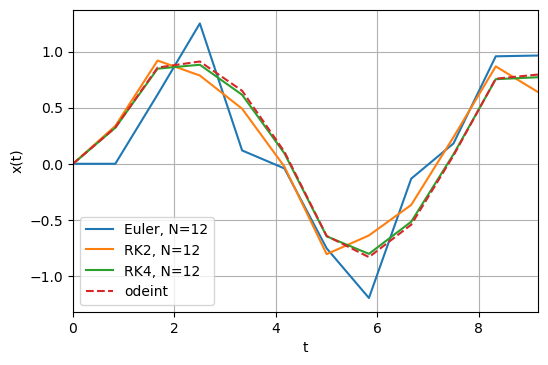

In [8]:
plt.figure(dpi=100)
plt.plot(tpoints, xEpoints, label='Euler, N={:d}'.format(N))
plt.plot(tpoints, np.array(x2points), label='RK2, N={:d}'.format(N))
plt.plot(tpoints, np.array(x4points), label='RK4, N={:d}'.format(N))
plt.xlabel("t")
plt.ylabel("x(t)")
plt.plot(tpoints, x_new, '--', label='odeint')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.legend()